# LDA Topic Modeling

Topic modelling is a technique to extract hidden topics from large volume of text. 

LDA represents topics as word probabilities and allows for uncovering hidden topics as it clusters words based ontheir co-occurrence in a respective document.

### Assumptions for LDA
1. Documents with similar topics use similar groups of words
2. Latent topics can be found by searching for groups of words that frequently occur together in documents across corpus
3. Documents are probability distributions over latent topics that signifies certain document will contain more words of specific topic
4. Topics themselves are probability distribution over words

### Goal: To find out what users speak about

One can use any vectorizer and not just count vectorizer e.g. tfidf - experiment!

### Steps that we will follow:
1. Prepare data
2. Find optimal number of topics
3. Fit optimal model
4. Transform training data and assign topics
5. Transform entire dataset and plot topics over time

In [60]:
# Setting to ignore warnings
import warnings
warnings.filterwarnings("ignore")


# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import nltk
import numpy as np
from nltk.tokenize import RegexpTokenizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# Text processing libraries
import re
from nltk.corpus import stopwords
import emoji
import contractions  # from https://github.com/kootenpv/contractions
import string

pd.set_option('display.max_colwidth', 120)

## 1 Prepare Data

In [61]:
# Read data and clean a bit
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
data_in = spotify.copy()
data_in = data_in.drop_duplicates(subset="Review")  # Drop dupes in Reviews
data_in.drop(["Time_submitted", "Total_thumbsup",
             "Reply"], axis=1, inplace=True)
data_in["Length"] = data_in["Review"].str.split(" ").str.len()
data_in = data_in[data_in.Length < 150]
data_in.drop(["Length"], axis=1, inplace=True)
data = data_in
data.head(10)

,Review,Rating
0,"Great music service, the audio is high quality and the app is easy to use. Also very quick and friendly support.",5
1,Please ignore previous negative rating. This app is super great. I give it five stars+,5
2,"This pop-up ""Get the best Spotify experience on Android 12"" is too annoying. Please let's get rid of this.",4
3,Really buggy and terrible to use as of recently,1
4,Dear Spotify why do I get songs that I didn't put on my playlist??? And why do we have shuffle play?,1
5,The player controls sometimes disappear for no reason. App restart forgets what I was playing but fixes the issue.,3
6,I love the selection and the lyrics are provided with the song you're listening to!,5
7,"Still extremely slow when changing storage to external sd card.. I'm convinced this is done on purpose, spotify knows of this issue and has done N...",3
8,"It's a great app and the best mp3 music app I have ever used but there is one problem that, why can't we play some songs or find some songs? despi...",5
9,"I'm deleting this app, for the following reasons: This app now has a failing business model. Whether streaming services like it, or not: the consu...",1


In [62]:
## Define a function to do some text cleaning
def clean_text(text):
    text = emoji.demojize(text)  # fix emojis
    text = contractions.fix(text)  # fix contractions
    text = re.sub(r'[^\x00-\x7f]', r'', text)  # remove strange fonts
    text = re.sub(r"\d+", "number", text)  # replace numbers with "number"
    text = re.sub(r'[^\w\s]', '', text)  # remove non-alphanumeric chars
    text = re.sub(r'\b\w{1}\b', '', text) # remove words less than 3 characters
    text = text.replace('_', ' ')  # replace underscores with space
    text = text.strip()  # strip extra spaces
    return text.lower()

In [63]:
## Test our text cleaner
clean_text("I ❤️ Spotify, even though it is critizised for exploiting artists")

'red heart spotify even though it is critizised for exploiting artists'

In [64]:
## Apply to all data
data["Review"] = data["Review"].apply(clean_text)

In [65]:
## Tokenize/remove punctuations
tokenizer = RegexpTokenizer(r'\w+')

In [66]:
data["Tokens"] = data["Review"].apply(tokenizer.tokenize)

In [67]:
data.sample(10)

,Review,Rating,Tokens
30695,although for long time was reluctant to use paying music service because of how badly the artists are treated have been growing more attached ...,2,"[although, for, long, time, was, reluctant, to, use, paying, music, service, because, of, how, badly, the, artists, are, treated, have, been, grow..."
37912,awful awful upgrade loudly crying face have spotify premium and following the update can no longer see the name of songs playing at the bottom o...,1,"[awful, awful, upgrade, loudly, crying, face, have, spotify, premium, and, following, the, update, can, no, longer, see, the, name, of, songs, pla..."
52912,very good app with wide genre of music,5,"[very, good, app, with, wide, genre, of, music]"
10697,it used to be ok because you would get ads like every number minutes or something like that but now it is awesome because think they removed ads ...,5,"[it, used, to, be, ok, because, you, would, get, ads, like, every, number, minutes, or, something, like, that, but, now, it, is, awesome, because,..."
1066,this is an amazing app revolving heartsbutterfly wld love if liked songs can be played without using internet pleading facepaw printsmaple leaf,5,"[this, is, an, amazing, app, revolving, heartsbutterfly, wld, love, if, liked, songs, can, be, played, without, using, internet, pleading, facepaw..."
15382,does not support lyrics even though it is already updated,1,"[does, not, support, lyrics, even, though, it, is, already, updated]"
59470,you know id really appreciate it if spotify could stop removing and not bringing back some of my favorite albums have been wanting to listen to b...,1,"[you, know, id, really, appreciate, it, if, spotify, could, stop, removing, and, not, bringing, back, some, of, my, favorite, albums, have, been, ..."
58740,spotify let us you listen to all of your favorite songs andor podcasts you can even create your own playlists and listen to music offline,5,"[spotify, let, us, you, listen, to, all, of, your, favorite, songs, andor, podcasts, you, can, even, create, your, own, playlists, and, listen, to..."
32657,stop just go and download boomplay much better app but just to support barcelona download it but never use it use boomplay or something else just...,2,"[stop, just, go, and, download, boomplay, much, better, app, but, just, to, support, barcelona, download, it, but, never, use, it, use, boomplay, ..."
53785,love red heart the variety of music trending old school music love all music the peace the gospel music brings me have the options of what decad...,5,"[love, red, heart, the, variety, of, music, trending, old, school, music, love, all, music, the, peace, the, gospel, music, brings, me, have, the,..."


In [68]:
# Get NLTK English stopwords
our_stopwords = set(stopwords.words('english'))
additional_stopwords = ["spotify", "app", "apps", "music", "songs", "song"]
our_stopwords.update(additional_stopwords)
#our_stopwords.remove("not")
# Remove stopwords
# We loop through each list of words and remove stopwords
data['Tokens'] = data['Tokens'].apply(lambda x: [word for word in x if word not in (our_stopwords)])
data.sample(5)

,Review,Rating,Tokens
44447,this new update completely got rid of the current song playing and the play and skip buttons it is completely missing no way for me to pause or sk...,1,"[new, update, completely, got, rid, current, playing, play, skip, buttons, completely, missing, way, pause, skip, close, completely, get, stop, pl..."
38867,this app would become best for music if there was no ad intrepution in between of songsi have been using this app for almost two years and am irr...,1,"[would, become, best, ad, intrepution, songsi, using, almost, two, years, irritated, intrepution, favourite, ridiculous, keeps, going, day, close,..."
51152,hey spotify no means no stop playing songs thumbed down it will not stop playing stuff that say do not like and it keeps forcing rb on me even ...,1,"[hey, means, stop, playing, thumbed, stop, playing, stuff, say, like, keeps, forcing, rb, even, though, like, rb, seems, play, top, number, cannot..."
59354,its keep shut look like in progress but it freeze tried uninstall and install again but still the same update nothing changed understand why there...,1,"[keep, shut, look, like, progress, freeze, tried, uninstall, install, still, update, nothing, changed, understand, button, report, problem, may, a..."
34482,spotify keeps stopping and no longer have control of the music cannot even top the music from playing have to restart my phone to make it stop ...,1,"[keeps, stopping, longer, control, cannot, even, top, playing, restart, phone, make, stop, skip, forward, backwards, paid, premium, currently, wor..."


In [69]:
## Split data in train and test
X_train, X_test = train_test_split(data['Tokens'], test_size=0.25, random_state=42)
print(X_train.shape, X_test.shape)

(46009,) (15337,)


In [70]:
## Count Vectorizer
def dummy(doc):
    return doc

count_vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy, max_features = 10000, ngram_range = (1,3))

X_train_counts = count_vectorizer.fit_transform(X_train)


In [71]:
## make TFIDF matrix
tfidf_vectorizer = TfidfTransformer()

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_counts)

In [72]:
## Get number of features from vectorizer and it shall match number of features that we provide to it
len(count_vectorizer.get_feature_names())

10000

In [73]:
# #! pip install tmtoolkit
# from tmtoolkit.topicmod.evaluate import metric_coherence_gensim
# # lda_model - LatentDirichletAllocation()
# # vect - CountVectorizer()
# # texts - the list of tokenized words
# metric_coherence_gensim(measure='c_v', 
#                         top_n=25, 
#                         topic_word_distrib=LDA.components_, 
#                         dtm=X_train_counts, 
#                         vocab=np.array([x for x in count_vectorizer.vocabulary_.keys()]), 
#                         texts=data_train["Tokens"])

## 2. Find optimal number of topics

In [74]:
# Search for ideal number of topics;
# Takes about 12 minutes
n_topics = [2,4,6,8,10,12,16,20,30,50,75,100]

perplexities = []
log_likelihood = []
# gensim_metrics = []
for n_topic in n_topics:
    LDA = LatentDirichletAllocation(n_components=n_topic,random_state=42)
    LDA.fit(X_train_tfidf)

    perplexities.append(LDA.perplexity(X_train_counts))
    log_likelihood.append(LDA.score(X_train_counts))

In [75]:
lda_results = pd.DataFrame(
    {'N_Topics': n_topics,
     'Perplexity': perplexities,
     'LLH': log_likelihood}
    )
lda_results

,N_Topics,Perplexity,LLH
0,2,2309.699865,-6.454260e+06
1,4,2130.943891,-6.387130e+06
2,6,2127.108591,-6.385629e+06
3,8,2151.372570,-6.395081e+06
4,10,2200.344867,-6.413839e+06
5,12,2235.053760,-6.426882e+06
6,16,2323.649392,-6.459277e+06
7,20,2352.623588,-6.469605e+06
8,30,2621.345625,-6.559738e+06
9,50,2943.759711,-6.656407e+06


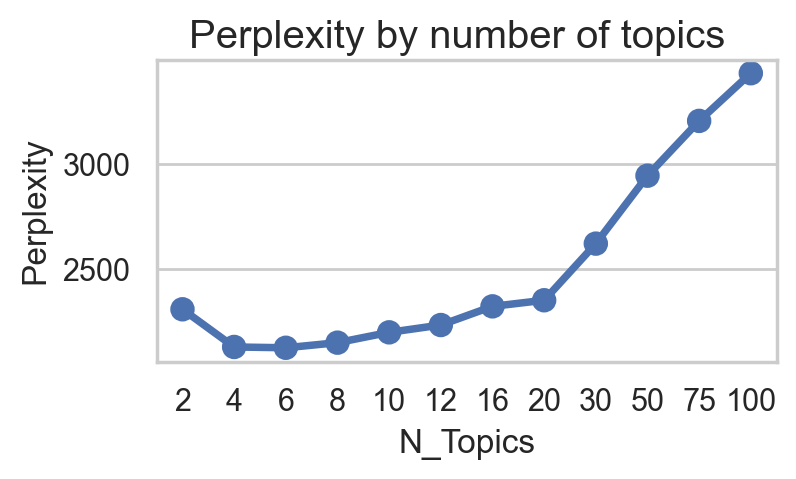

In [76]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(4,2),dpi=200)

plt.suptitle("Perplexity by number of topics");
sns.pointplot(x="N_Topics",
              y="Perplexity",
              data=lda_results);

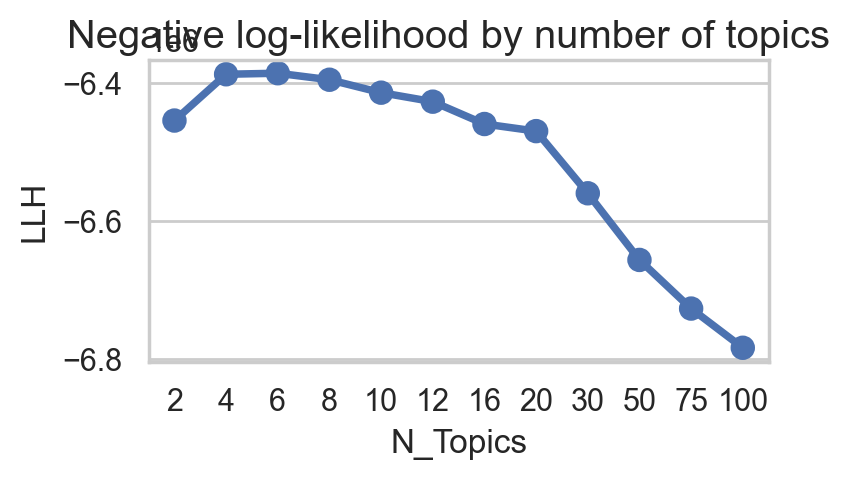

In [77]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(4,2),dpi=200)

plt.suptitle("Negative log-likelihood by number of topics");
sns.pointplot(x="N_Topics",
              y="LLH",
              data=lda_results);

## 3. Fit optimal model

In [78]:
## Final model
LDA = LatentDirichletAllocation(n_components=6,random_state=42)
LDA.fit(X_train_tfidf)

LatentDirichletAllocation(n_components=6, random_state=42)

In [79]:
## Number of components (=topics)
n_components = len(LDA.components_)
print("Number of components: ", n_components)

Number of components:  6


In [80]:
# print n top words per component
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([count_vectorizer.get_feature_names()[index] for index in (-topic).argsort()[:15]])
    print('\n')

THE TOP 15 WORDS FOR TOPIC #0
['number', 'ads', 'premium', 'would', 'like', 'get', 'playlist', 'free', 'every', 'ad', 'listen', 'many', 'one', 'stars', 'pay']


THE TOP 15 WORDS FOR TOPIC #1
['playing', 'update', 'stop', 'keeps', 'play', 'fix', 'bar', 'pause', 'phone', 'stops', 'randomly', 'cannot', 'last', 'bugs', 'please']


THE TOP 15 WORDS FOR TOPIC #2
['cannot', 'even', 'account', 'downloaded', 'offline', 'internet', 'fix', 'log', 'working', 'play', 'connection', 'tried', 'premium', 'please', 'work']


THE TOP 15 WORDS FOR TOPIC #3
['play', 'want', 'listen', 'like', 'good', 'playlist', 'cannot', 'love', 'plays', 'great', 'want listen', 'one', 'hear', 'random', 'even']


THE TOP 15 WORDS FOR TOPIC #4
['great', 'easy', 'good', 'use', 'easy use', 'quality', 'love', 'podcasts', 'selection', 'sound', 'amazing', 'nice', 'excellent', 'like', 'experience']


THE TOP 15 WORDS FOR TOPIC #5
['best', 'love', 'face', 'good', 'smiling', 'ever', 'favorite', 'streaming', 'listen', 'listening', 'g

In [24]:
## Let's give a descriptive name to the topics
lda_topics = ['phone_update_issue', 'spotify_is_awesome', 'internet_connection_issue', 'too_many_ads','playlists_and_songs', 'premium_account']

In [25]:
# turn this into a handy df
def get_model_topics(model, vectorizer, topics, n_top_words=10):    
    word_dict = {}    
    feature_names = vectorizer.get_feature_names()    
    for topic_idx, topic in enumerate(model.components_):        
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]        
        top_features = [feature_names[i] for i in top_features_ind]        
        word_dict[topics[topic_idx]] = top_features
    return pd.DataFrame(word_dict)

In [26]:
get_model_topics(LDA, count_vectorizer, lda_topics)

,phone_update_issue,spotify_is_awesome,internet_connection_issue,too_many_ads,playlists_and_songs,premium_account
0,update,music,face,ads,song,premium
1,playing,great,smiling,number,songs,account
2,phone,good,fix,ad,play,songs
3,play,easy,internet,song,best,log
4,music,use,please,songs,want,would
5,work,listen,connection,minutes,playlist,even
6,fix,best,every,every,music,lyrics
7,stop,songs,problem,skip,listen,listen
8,time,number,smiling face,number minutes,best music,number
9,last,really,song,number songs,shuffle,get


## 4. Transform training data and assign topics

In [27]:
topic_results = LDA.transform(X_train_tfidf)
topic_results

array([[0.03051587, 0.03041899, 0.46156897, 0.0300627 , 0.417006  ,
        0.03042746],
       [0.03818714, 0.03770315, 0.03752222, 0.0373859 , 0.03789031,
        0.81131128],
       [0.02538715, 0.02598572, 0.02522632, 0.02528601, 0.02523118,
        0.87288362],
       ...,
       [0.03558099, 0.28008173, 0.03535758, 0.03531954, 0.03510628,
        0.57855389],
       [0.03229209, 0.83812685, 0.03217406, 0.03227717, 0.03272834,
        0.03240148],
       [0.05077349, 0.74552369, 0.05073228, 0.05080867, 0.05136282,
        0.05079904]])

In [28]:
# Split original data
data_train, _ = train_test_split(data, test_size=0.25, random_state=42)

In [29]:
pd.set_option('display.max_colwidth', 150)
data_train['Topic_number'] = topic_results.argmax(axis=1)
data_train[["Review", "Topic_number"]].head(10)

,Review,Topic_number
29893,great app best music platform but the group session feature needs work still they should add controll feature that let us someone be host of the ...,2
29959,spotifys best feature is the notifications for new releases by artists you follow but that feature has not been working for months after several u...,5
54863,would have gave number stars if spotify completely supported joe rogans freedom of expression and did not delete those number episodes am not fa...,5
54056,have to uninstall and reinstall multiple times to receive any new music podcast etc very buggy and have android lol,0
24842,good quantity of music and quality,1
2890,my experience with spotify is great love this platform thanks spotify team,1
9323,great to be able to create own playlist from number of choices,1
34086,there is one request for spotify please add recently added songs,4
38814,highly suggest not getting this have tried number months now to cancel my subscription it says its canceled yet they keep taking funds from me tr...,5
60771,really liked spotify at first but then it got updated or something and now it has gotten very annoying cannot enter my playlists to pick songs th...,5


In [30]:
# log-likelihood (measure of how plausible model parameters are given the data); lower is better 
# (it is actually NEGATIVE LLH; as every metric in sklearn is implemented so that lower is better)
print(LDA.score(X_train_counts))
# Perplexity (a measure of model's "surprise" at the data); lower is better
print(LDA.perplexity(X_train_counts))

-6709929.53515921
2083.257850658416


In [31]:
def assign_topic_name(topic_number):
    if topic_number == 0:
        return lda_topics[0]
    if topic_number == 1:
        return lda_topics[1]
    if topic_number == 2:
        return lda_topics[2]
    if topic_number == 3:
        return lda_topics[3]
    if topic_number == 4:
        return lda_topics[4]
    if topic_number == 5:
        return lda_topics[5]


data_train["Topic_name"] = data_train["Topic_number"].apply(assign_topic_name)

In [32]:
data_train[["Review", "Topic_name"]].sample(10)

,Review,Topic_name
1391,cannot play an individual song cannot choose specific playlist will not play songs in order and cannot listen offline or in between apps,playlists_and_songs
8265,struggle to connect with amazon echo auto,phone_update_issue
52234,awful app podcasts constantly stop you cannot see what you are listening to either very disappointing,phone_update_issue
209,way too many ads and it is always the same annoying number ffs,too_many_ads
22874,love it it is everything you wa to listen to muzic great appliation nothing this time to complain about may be next time,phone_update_issue
39787,this is great app but sometimes the ad will come in between the song but it is gerat app,too_many_ads
33598,relentless bluetooth popup,phone_update_issue
55940,there are too many adds pls reduce the amount of adds in normal subscription also,spotify_is_awesome
3970,love spotify premium it is affordable can listen from all my devices and get showtime as bonus,spotify_is_awesome
19311,music musical notes thought that would never heard again and music have never heard some of the best music listen to it all the time,playlists_and_songs


In [33]:
topic_f = pd.DataFrame(data_train["Topic_name"].value_counts()).reset_index()
topic_f.columns = ["Topic_name", "Count"]
topic_f

,Topic_name,Count
0,spotify_is_awesome,14246
1,phone_update_issue,10862
2,premium_account,7636
3,playlists_and_songs,6809
4,too_many_ads,3775
5,internet_connection_issue,2681


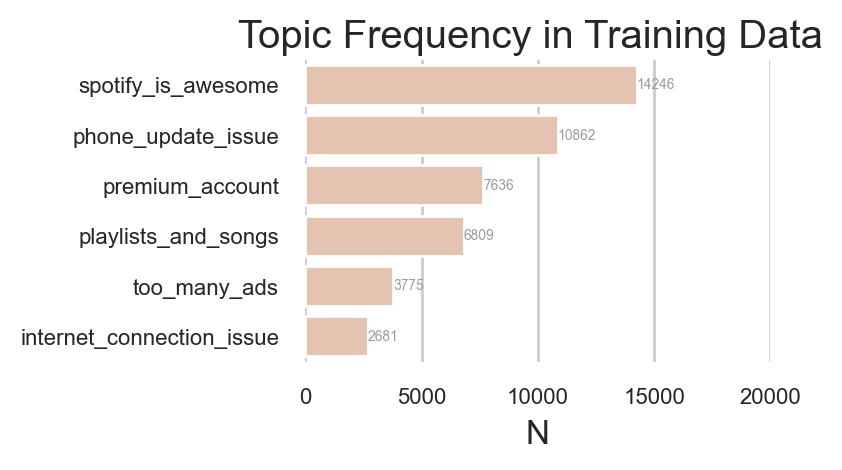

In [34]:
## Plot
sns.set_theme(style="whitegrid")

f, ax = plt.subplots(figsize=(3,2),dpi=200)

sns.set_color_codes("pastel")
sns.barplot(x="Count", 
            y="Topic_name", 
            data=topic_f,
            color = "#EDC2A7")

ax.set(xlim=(0, 20000), ylabel="",
       xlabel="N")
ax.bar_label(ax.containers[0], size=5, label_type="edge", padding=0, color="#999DA0")
plt.suptitle("Topic Frequency in Training Data")

ax.tick_params(labelsize=8)

sns.despine(left=True, bottom=True)

## 5. Transform entire dataset and plot topics over time

In [35]:
## define pipeline to predict a topic from a single input
def predict_topic(text):
    text_clean = clean_text(text)
    tokens = tokenizer.tokenize(text_clean)
    tokens_clean = [word for word in tokens if word not in (our_stopwords)]
    counts = count_vectorizer.transform([tokens_clean])
    tfids = tfidf_vectorizer.transform(counts)
    topics = LDA.transform(tfids)
    topic = topics.argmax(axis=1).flat[0]
    topic_name = lda_topics[topic]
    return topic_name


In [36]:
predict_topic("I downloaded this app yesterday great playlists")

'spotify_is_awesome'

In [37]:
# Read data and clean a bit
spotify = pd.read_csv("../data/raw/spotify_review_kaggle.csv")
ts_data = spotify.copy()
ts_data = ts_data.drop_duplicates(subset="Review")  # Drop dupes in Reviews
ts_data.drop(["Total_thumbsup",
             "Reply"], axis=1, inplace=True)
ts_data["Length"] = ts_data["Review"].str.split(" ").str.len()
ts_data = ts_data[ts_data.Length < 150]
ts_data.drop(["Length"], axis=1, inplace=True)
ts_data["Time_submitted"] = pd.to_datetime(ts_data["Time_submitted"])
ts_data["Topic"] = ts_data["Review"].apply(predict_topic)

In [59]:
ts_data.sample(10)

,Time_submitted,Review,Rating,Topic
4609,2022-06-29 13:32:57,Always a great selection of music. Never disappointed 😉 It's my go to daily,5,spotify_is_awesome
1320,2022-07-06 18:08:02,"I can't use my spotify, I don't know what happened.",1,phone_update_issue
15659,2022-06-02 13:31:04,Best app for music and consumes less mobile data,5,spotify_is_awesome
24787,2022-05-07 05:43:40,It is easy to use and very useful.,4,spotify_is_awesome
16843,2022-05-30 05:29:56,Doesn't always connect well and offline mode more often than not will not work.,3,phone_update_issue
3659,2022-07-01 13:25:49,I keep having to reinstall. App will not function normally for over a month. It plays with the button on pause and there is no way to stop it besi...,2,phone_update_issue
9207,2022-06-19 02:20:57,STILL the best music app I have ever had!,5,playlists_and_songs
36795,2022-04-13 13:26:32,Spotify allows me to find new music that I love ❤️ great playlists too,5,spotify_is_awesome
48022,2022-03-04 22:50:26,you have to pay for most features but however the console versions are totally free!!! Edit: the recommendations are great but the need to pay sucks.,3,spotify_is_awesome
18565,2022-05-25 13:20:26,Thought premium meant no ads,1,premium_account


In [93]:
ts_df = ts_data.resample('W', on='Time_submitted')['Topic'].value_counts()
ts_df = pd.DataFrame(ts_df)
ts_df.columns = ["Topic_count"]
ts_df = ts_df.reset_index()
ts_df.columns = ["Week", "Topic", "Topic_count"]

ts_df = ts_df.pivot_table('Topic_count', ['Week'], 'Topic').reset_index()
ts_df["Week"] = ts_df["Week"].astype(str)
ts_df.head(10)

Topic,Week,internet_connection_issue,phone_update_issue,playlists_and_songs,premium_account,spotify_is_awesome,too_many_ads
0,2022-01-02,4,15,8,13,31,17
1,2022-01-09,17,94,54,79,131,36
2,2022-01-16,30,193,114,141,241,70
3,2022-01-23,85,263,231,219,444,128
4,2022-01-30,92,315,293,605,731,193
5,2022-02-06,80,361,272,583,704,198
6,2022-02-13,98,370,261,394,622,168
7,2022-02-20,97,373,292,296,610,151
8,2022-02-27,101,289,246,273,595,136
9,2022-03-06,111,329,218,240,532,99


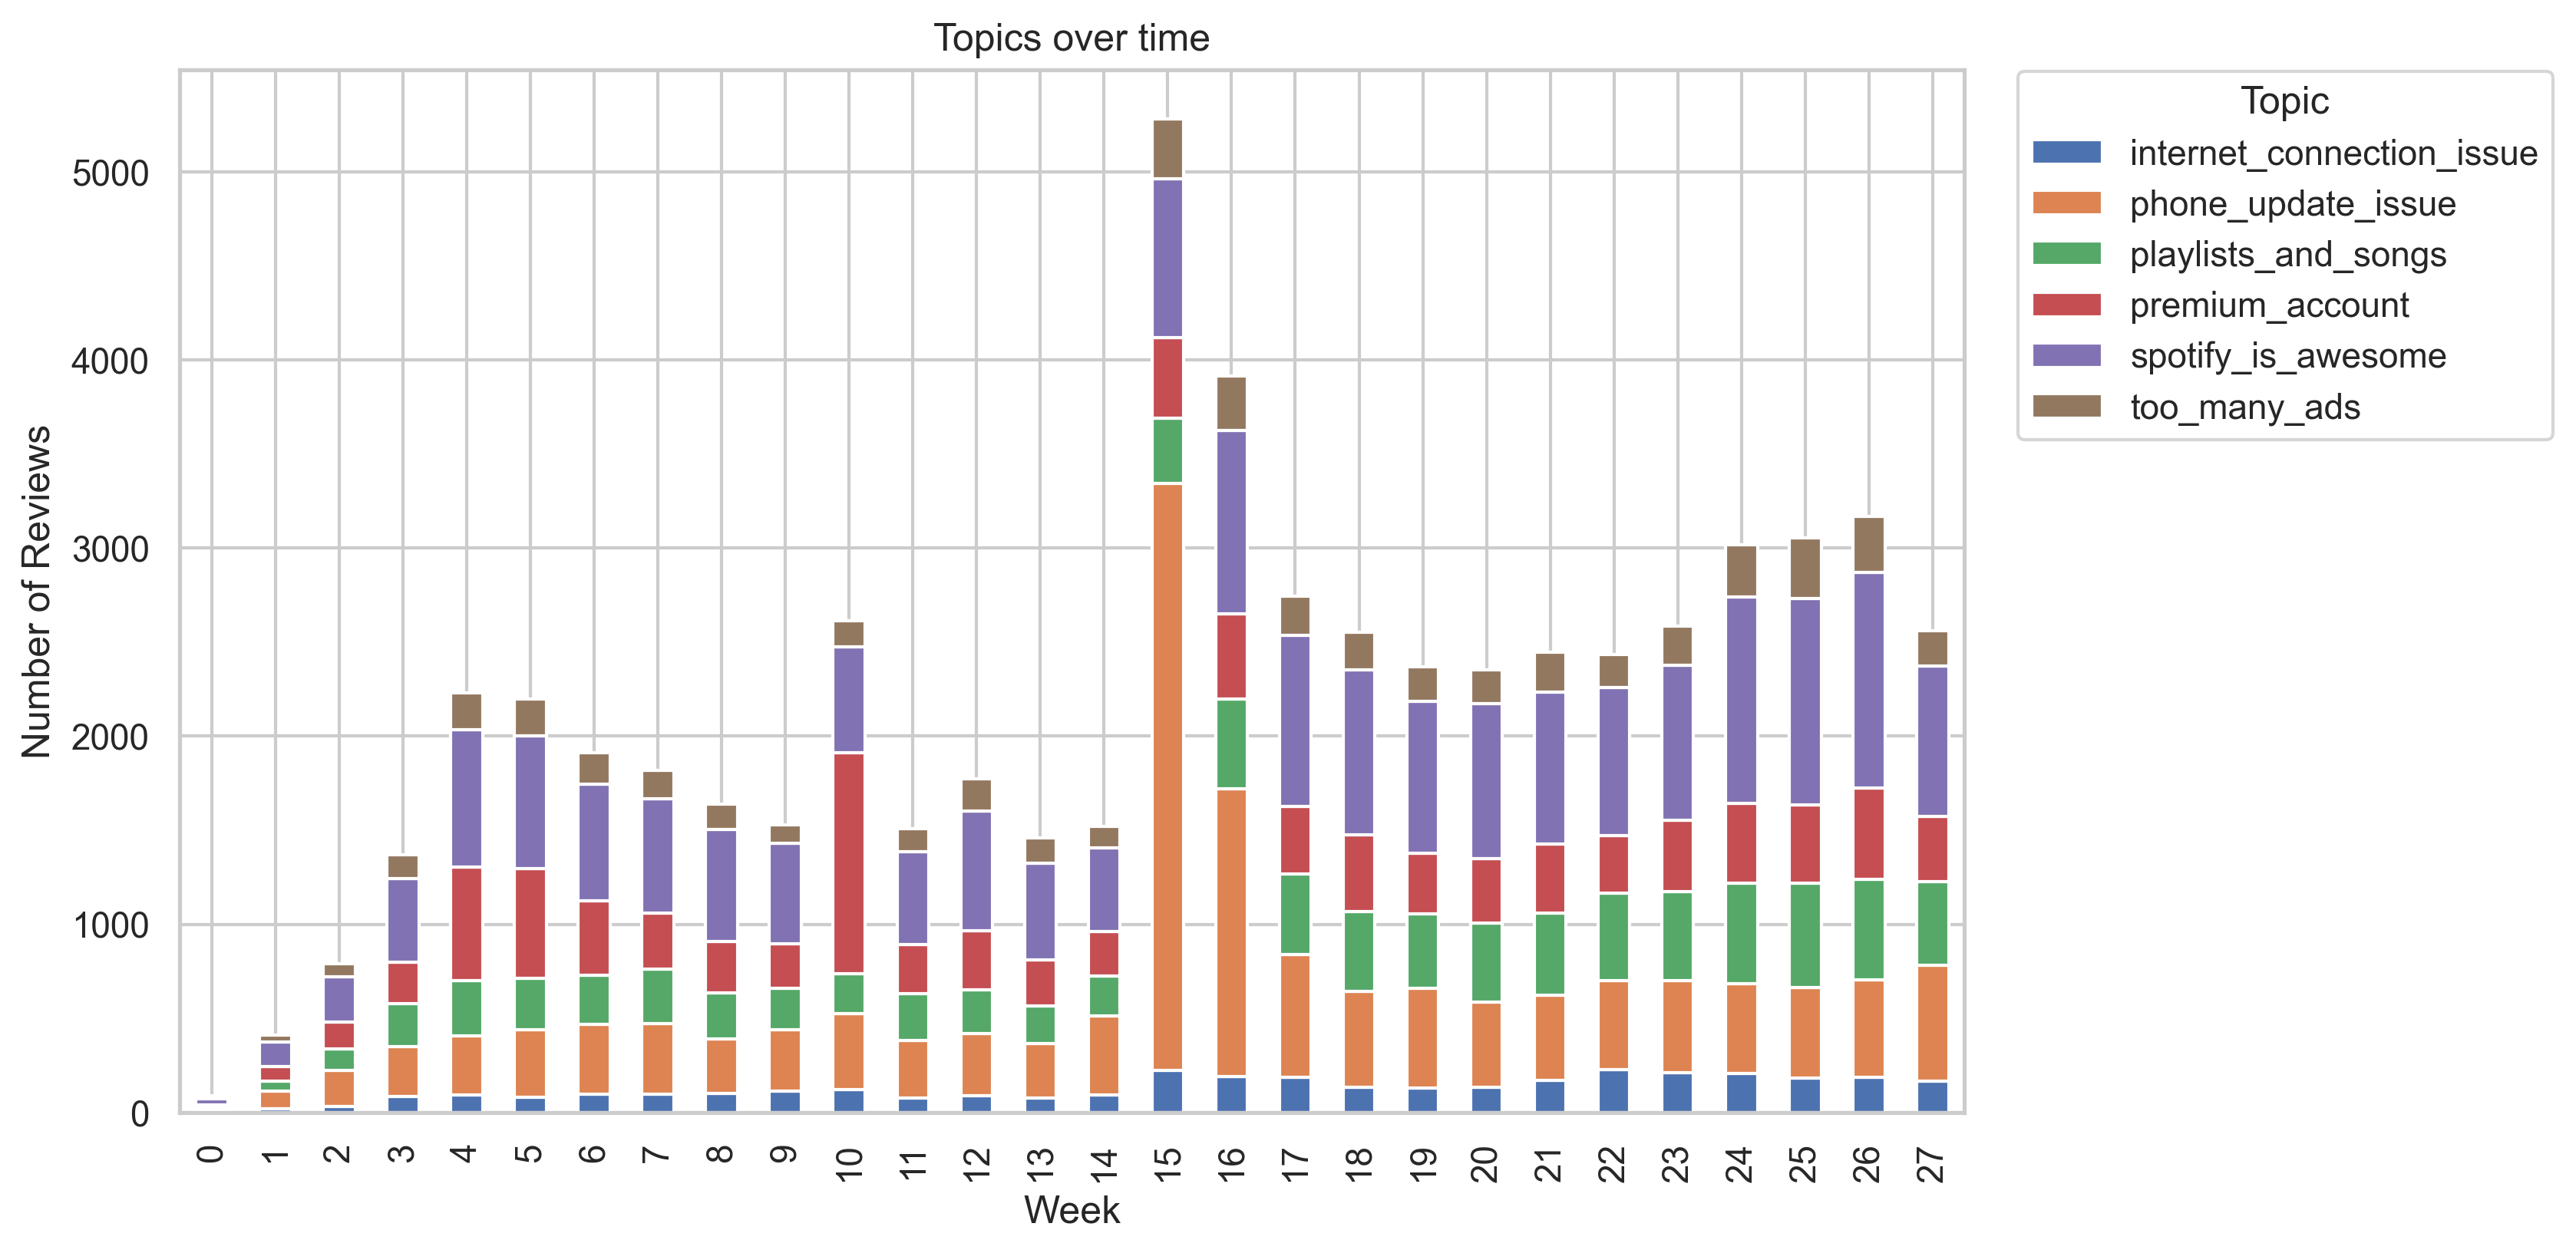

In [94]:
# plot the pivoted dataframe
plt.rcParams['figure.dpi'] = 300
ts_df.plot.bar(stacked=True, figsize=(10, 6), ylabel='Number of Reviews', xlabel='Week', title='Topics over time')
plt.legend(title='Topic', bbox_to_anchor=(1.02, 1.015), loc='upper left')
plt.show()

In [83]:
ts_df.head()

Topic,Week,internet_connection_issue,phone_update_issue,playlists_and_songs,premium_account,spotify_is_awesome,too_many_ads
0,2022-01-02,4,15,8,13,31,17
1,2022-01-09,17,94,54,79,131,36
2,2022-01-16,30,193,114,141,241,70
3,2022-01-23,85,263,231,219,444,128
4,2022-01-30,92,315,293,605,731,193


In [101]:
ts_df_props = ts_df

ts_df_props[lda_topics] = ts_df[lda_topics].div(ts_df[lda_topics].sum(axis=1), axis=0).multiply(100)
ts_df_props.head()

Topic,Week,internet_connection_issue,phone_update_issue,playlists_and_songs,premium_account,spotify_is_awesome,too_many_ads
0,2022-01-02,4.545455,17.045455,9.090909,14.772727,35.227273,19.318182
1,2022-01-09,4.136253,22.871046,13.138686,19.221411,31.873479,8.759124
2,2022-01-16,3.802281,24.461343,14.448669,17.870722,30.544994,8.871990
3,2022-01-23,6.204380,19.197080,16.861314,15.985401,32.408759,9.343066
4,2022-01-30,4.127411,14.131898,13.144908,27.142216,32.794975,8.658591


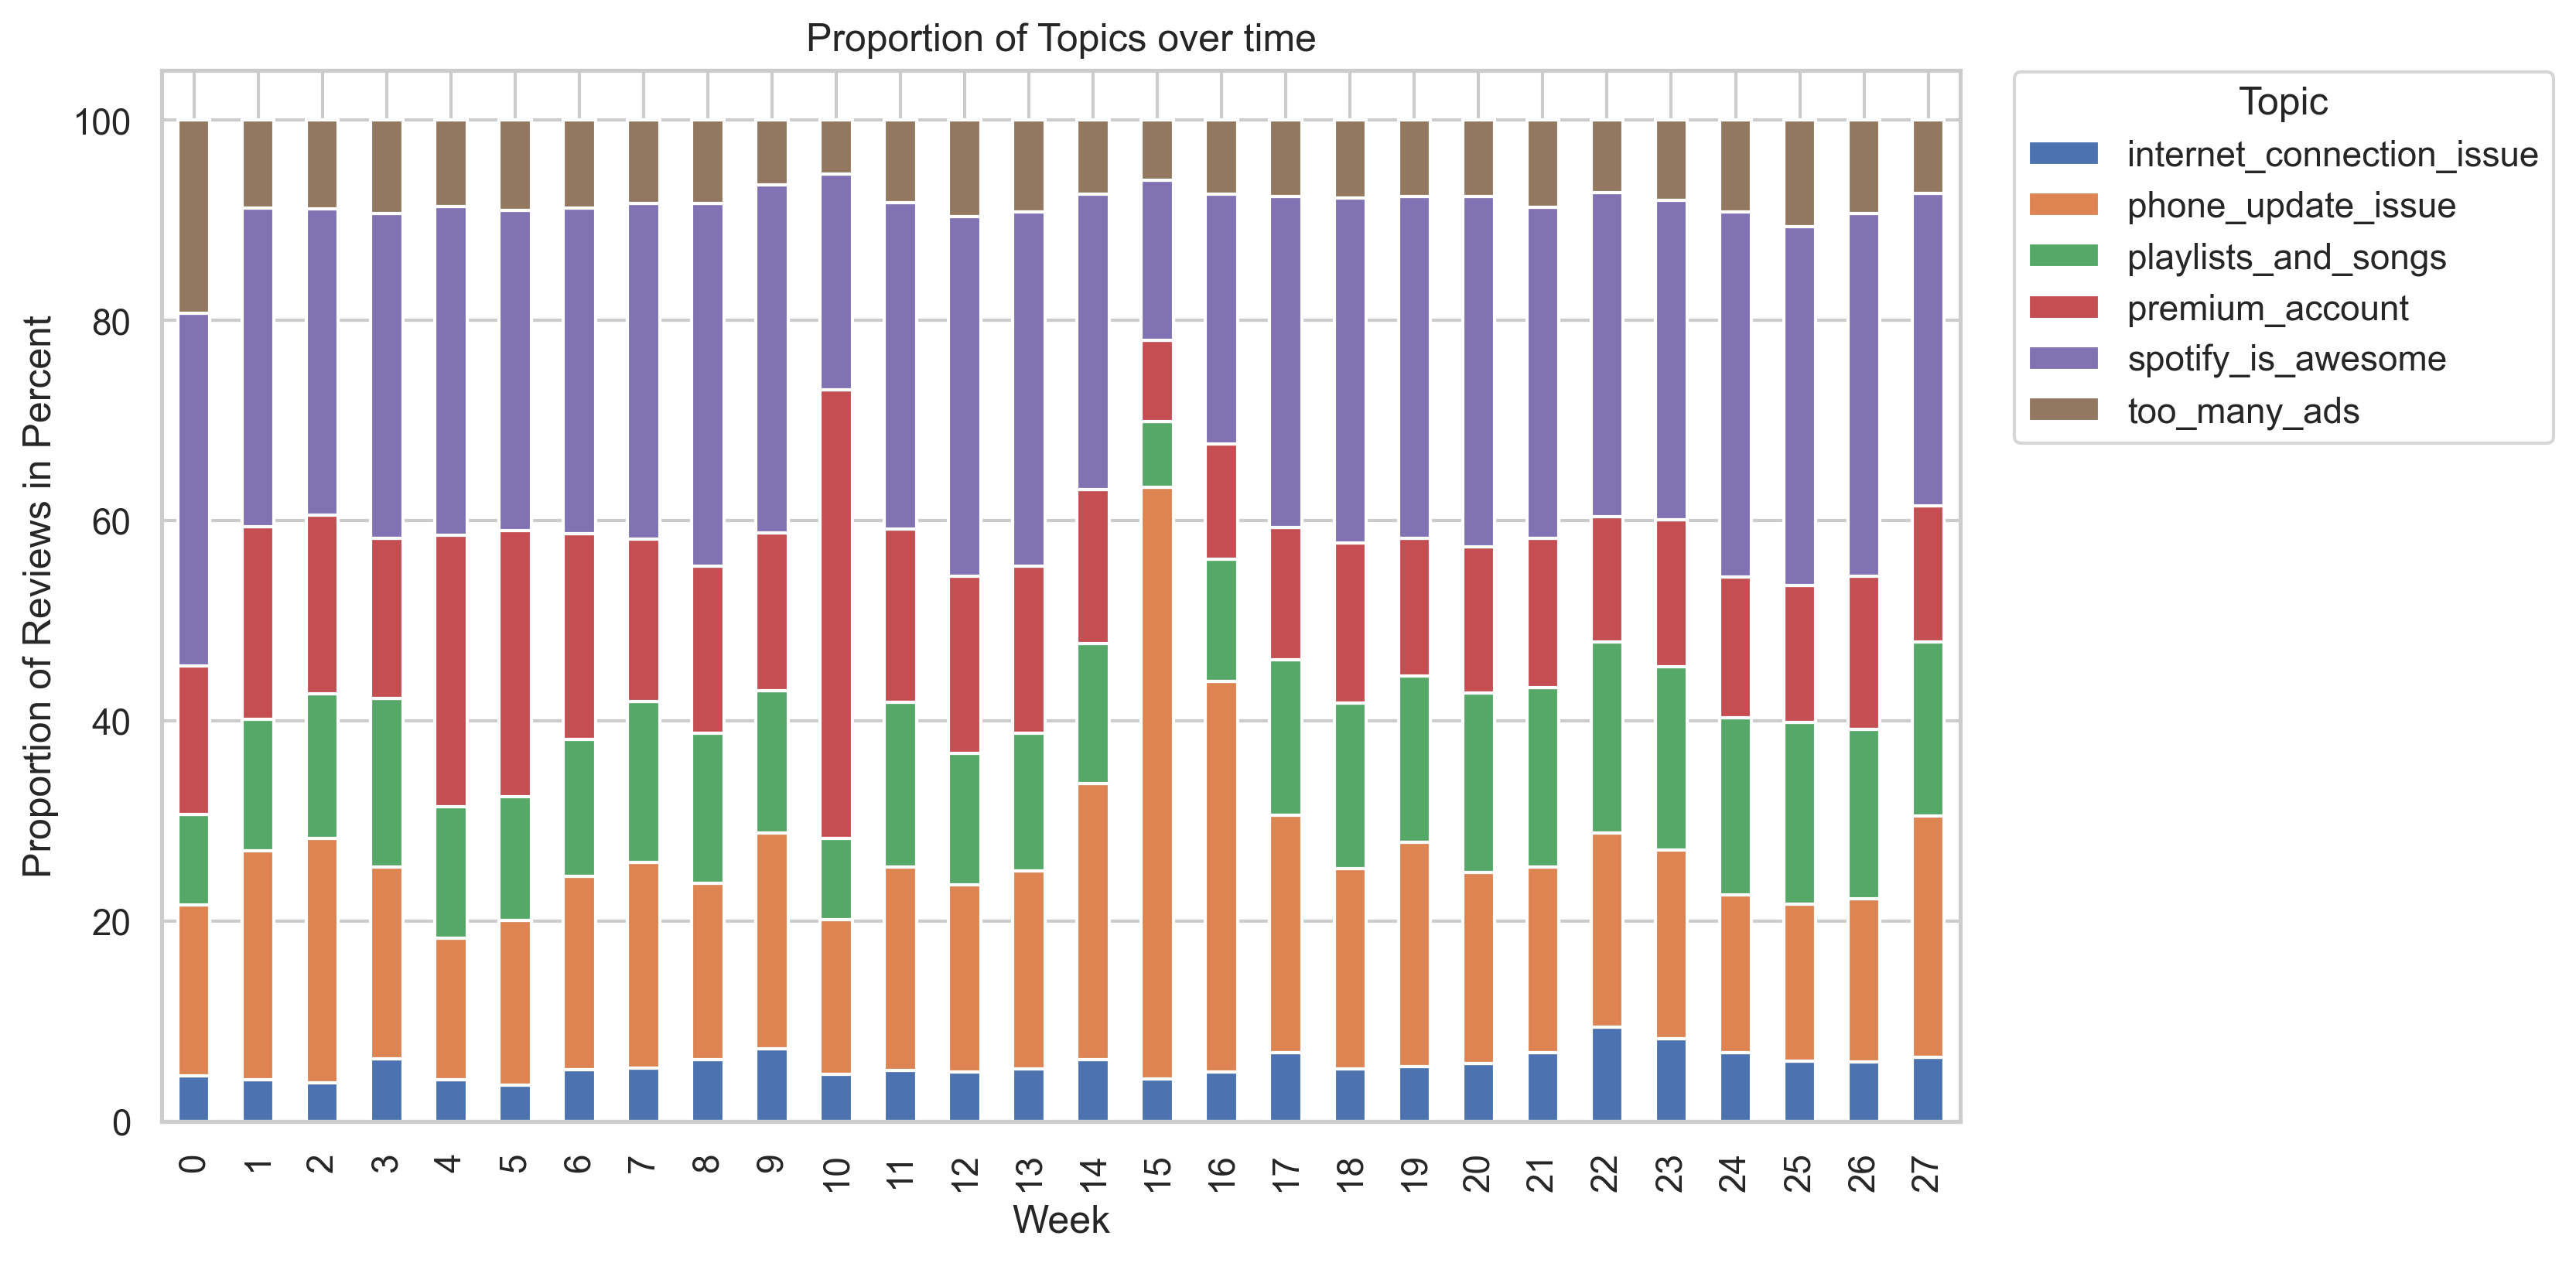

In [100]:
# plot the pivoted dataframe
plt.rcParams['figure.dpi'] = 300
ts_df_props.plot.bar(stacked=True, figsize=(10, 6), ylabel='Proportion of Reviews in Percent', xlabel='Week', title='Proportion of Topics over time')
plt.legend(title='Topic', bbox_to_anchor=(1.02, 1.015), loc='upper left')
plt.show()